<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Umap_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2305940 sha256=c73e7699face29d09838cce88dc26a71b023bb2f9280efc0309f374ab912f720
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [63]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [ ]:
mnist = fetch_openml('Fashion-MNIST', version=1)
mnist.target = mnist.target.astype(int)

In [14]:
nb_classes = 10
count_label = nb_classes
img_rows, img_cols = 28, 28
input_shape = [img_rows, img_cols, 1]


In [47]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


In [92]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import regularizers


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-6))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-6))(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-6))(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
print(x.shape)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(None, 14, 14, 16)
(None, 7, 7, 8)
(None, 4, 4, 8)
(None, 8, 8, 8)
(None, 16, 16, 8)
(None, 28, 28, 16)
(None, 28, 28, 1)


In [41]:
encoding_dim = (28, 28, 16) 
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=encoding_dim)
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

TypeError: ignored

In [90]:
!tensorboard --logdir=/tmp/autoencoder

2020-07-30 08:56:27.334579: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [93]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.2924 - val_loss: 0.2180
Epoch 2/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.2052 - val_loss: 0.1954
Epoch 3/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.1853 - val_loss: 0.1757
Epoch 4/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.1732 - val_loss: 0.1685
Epoch 5/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.1648 - val_loss: 0.1635
Epoch 6/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.1595 - val_loss: 0.1586
Epoch 7/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.1554 - val_loss: 0.1607
Epoch 8/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.1526 - val_loss: 0.1494
Epoch 9/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.1504 - val_loss: 0.1462
Epoch

In [94]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
#x_pred = encoder.predict(np.expand_dims(x_test[0],0))
x_preds = encoder.predict(x_test)
#plt.imshow(x_pred)
embedding = x_preds.reshape(x_preds.shape[0],x_preds.shape[1]*x_preds.shape[2]*x_preds.shape[3])

In [20]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


ValueError: ignored

<Figure size 1440x288 with 0 Axes>

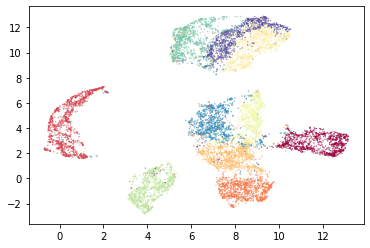

In [48]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_test, s=0.1, cmap='Spectral');

In [49]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

AttributeError: ignored

In [ ]:
(
    adjusted_rand_score(mnist.target, kmeans_labels),
    adjusted_mutual_info_score(mnist.target, kmeans_labels)
)


(0.374131283278033, 0.512165010391304)

In [50]:
#lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(standard_embedding)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


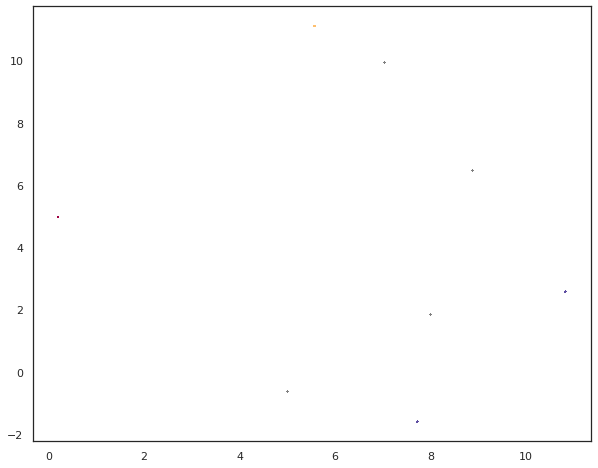

In [71]:
#clustered = (hdbscan_labels >= 0)
clustered = hdbscan_labels

plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');


In [53]:
(
    adjusted_rand_score(y_test, hdbscan_labels),
    adjusted_mutual_info_score(y_test, hdbscan_labels)
)


(0.3126824064345673, 0.5889700660045607)

In [56]:
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(y_test[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(y_test[clustered], hdbscan_labels[clustered])
)

(0.3126824064345673, 0.5889700660045607)

In [57]:
np.sum(clustered) / x_test.shape[0]

1.0

In [102]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=100,
    random_state=42,
).fit_transform(embedding)


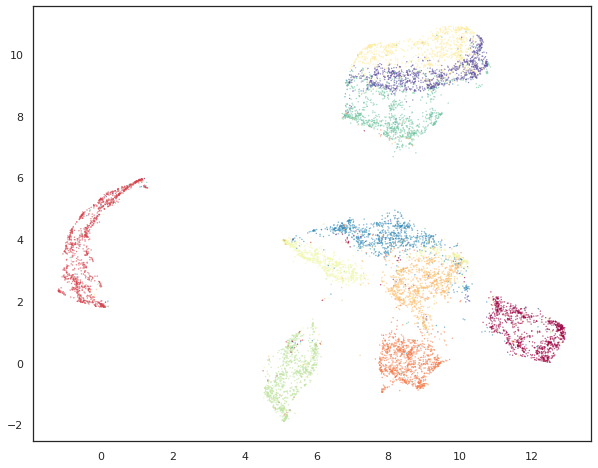

In [64]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=y_test, s=0.1, cmap='Spectral');


In [103]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


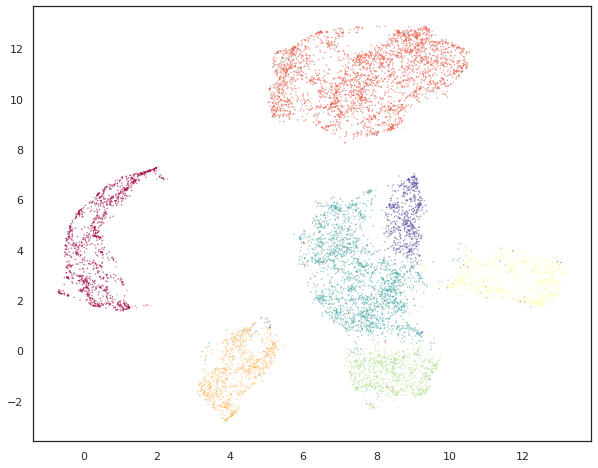

In [104]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [105]:
adjusted_rand_score(y_test, labels), adjusted_mutual_info_score(y_test, labels)

(0.5746760665295043, 0.7463859364403345)

In [85]:
clustered = (labels >= 0)
(
    adjusted_rand_score(y_test[clustered], labels[clustered]),
    adjusted_mutual_info_score(y_test[clustered], labels[clustered])
)


(0.5306909894596721, 0.744275726869276)

In [87]:
np.sum(clustered) / x_test.shape[0]

0.9868